In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from fontTools.ttLib.woff2 import bboxFormat
from pyextremes import *
from tqdm import tqdm
from seaborn import axes_style
from scipy.stats import rv_continuous
import scipy
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from fractional_levy_noise import *

# relative import
from EVT_approach import read_df

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define series
grid_name = 'uk'
season = 'spring'
df = read_df(grid_name, season)
series = df['Value']


Exponential Decay Parameters:
  a = 1.0509 ± 0.0014
  b = 0.1454 ± 0.0003
Power Law Decay Parameter:
  a = 0.7099 ± 0.0013


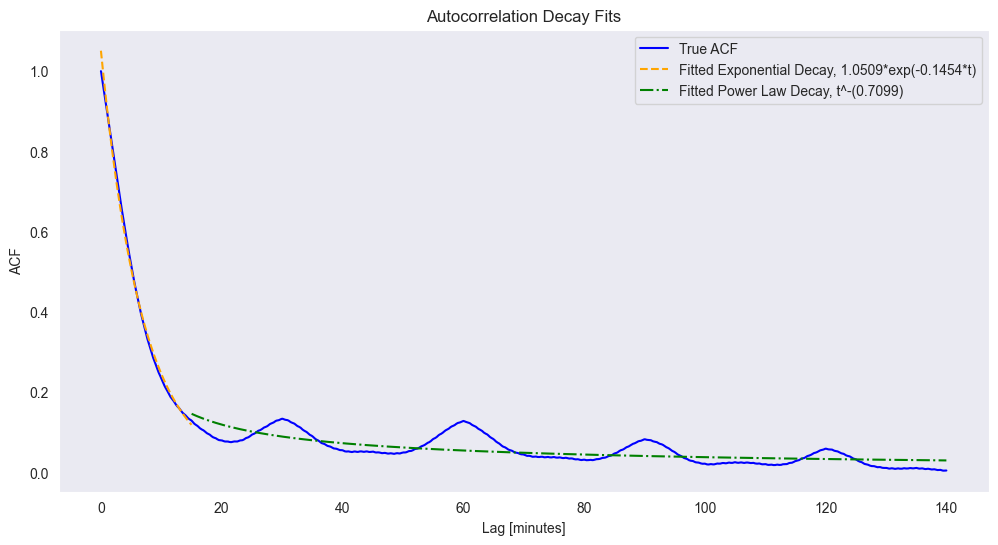

In [3]:
# Compute the ACF using the second-based data
acf_values = acf(df['Value'], nlags=8400)  # Adjust `nlags` to cover more minutes
lags = np.arange(len(acf_values)) / 60  # Convert lags from seconds to minutes

# Define the exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Define the power-law decay function
def power_law_decay(x, a, b):
    return a / (1 + b * x)

def power_law_decay_simple(x, a):
    return x**(-a)

# Estimate parameters for the first strong decay (exponential)
# Fit the exponential decay to the first part of the ACF
strong_decay_indices = lags <= 15  # Fit for lags up to 6 minutes, determined by np.argmin(acf_values[:15*60])=331
popt_exp, pcov_exp = curve_fit(exponential_decay, lags[strong_decay_indices], acf_values[strong_decay_indices], p0=(1, 1/60))

# Estimate parameters for the second, longer decay (power-law)
# Fit the power-law decay to the longer tail of the ACF
longer_decay_indices = lags > 15  # Fit for lags beyond 20 minutes
popt_power, pcov_power = curve_fit(power_law_decay_simple, lags[longer_decay_indices], acf_values[longer_decay_indices], p0=(1))

# Extract standard errors (sqrt of diagonal of covariance matrix)
perr_exp = np.sqrt(np.diag(pcov_exp))
perr_power = np.sqrt(np.diag(pcov_power))

# Print the estimated parameters with uncertainties
print(f"Exponential Decay Parameters:")
print(f"  a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
print(f"  b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")
print(f"Power Law Decay Parameter:")
print(f"  a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")

gamma_eff = popt_exp[1]  # Damping factor
H = (-popt_power[0] + 2)/2 # Hurst exponent

# Visualize the fits
plt.figure(figsize=(12, 6))

# Plot the ACF
plt.plot(lags, acf_values, label='True ACF', color='blue')

# Plot the fitted exponential decay
plt.plot(lags[strong_decay_indices], exponential_decay(lags[strong_decay_indices], *popt_exp),
         label=f'Fitted Exponential Decay, {popt_exp[0]:.4f}*exp(-{popt_exp[1]:.4f}*t)', linestyle='--', color='orange')

# Plot the fitted power-law decay
plt.plot(lags[longer_decay_indices], power_law_decay_simple(lags[longer_decay_indices], *popt_power),
         label=f'Fitted Power Law Decay, t^-({popt_power[0]:.4f})', linestyle='-.', color='green')

#f'Fitted Power Law Decay, {popt_power[0]:.4f} / (1 + {popt_power[1]:.4f}*x)'

# Label the plot
plt.xlabel('Lag [minutes]')
plt.ylabel('ACF')
plt.grid()
plt.title('Autocorrelation Decay Fits')
plt.legend()
plt.show()

Estimated σ from ROCOF residuals: 0.002647 Hz/s


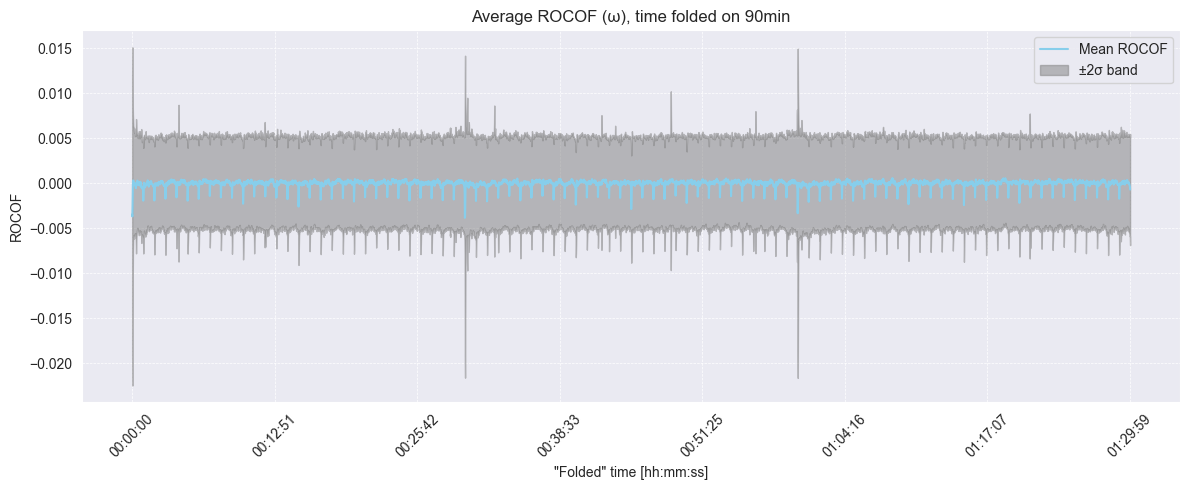

In [4]:
# FIGURE 4, ROCOF.

# Parameters
fold_period_sec = 90 * 60  # 90 minutes in seconds
dt = 1  # time step in seconds

# Step 1: Compute ROCOF (rate of change of frequency)
df['ROCOF'] = df['Value'].diff() / dt
df = df.dropna()

# Step 2: Compute 'folded' time
df['time_seconds'] = (df.index - df.index[0]).total_seconds()
df['folded_time'] = df['time_seconds'] % fold_period_sec
df['folded_bin'] = df['folded_time'].astype(int)

# Step 3: Group by folded_bin
grouped = df.groupby('folded_bin')['ROCOF']
mean_rocof = grouped.mean()
std_rocof = grouped.std()

# Step 4: Calculate residuals and estimate σ
df['mu_t'] = df['folded_bin'].map(mean_rocof)
residuals = df['ROCOF'] - df['mu_t']
sigma_est = residuals.std()

print(f"Estimated σ from ROCOF residuals: {sigma_est:.6f} Hz/s")

# Step 5: Plot
time_axis = pd.to_timedelta(mean_rocof.index, unit='s')

# Use float for plotting
x = mean_rocof.index.values.astype(float)

plt.figure(figsize=(12, 5))
plt.plot(x, mean_rocof, label='Mean ROCOF', color='skyblue')
plt.fill_between(x,
                 mean_rocof - 2 * std_rocof,
                 mean_rocof + 2 * std_rocof,
                 color='grey', alpha=0.5,
                 label='±2σ band')

# Generate formatted x-tick labels in hh:mm:ss
tick_locs = np.linspace(x[0], x[-1], num=8, dtype=int)
tick_labels = pd.to_timedelta(tick_locs, unit='s').astype(str).str.slice(7)  # remove '0 days '

plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)

plt.xlabel('"Folded" time [hh:mm:ss]')
plt.ylabel('ROCOF')
plt.title('Average ROCOF (ω), time folded on 90min')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# --- Model Parameters from Table II ---
gamma1 = 1 / 950      # Damping within deadband
gamma2 = 1 / 400      # Damping outside deadband
omega_db = 0.015      # Deadband threshold (Hz)
print("H", H)              # Hurst exponent
# alpha = 1.975         # Tail exponent for Lévy distribution
sigma = sigma_est        # Scale of fluctuations (empirical std dev)
print("sigma: ", sigma)
trunc = 100           # Truncate extremes of Lévy
,
dt = 1                # Time step (in seconds)
T = len(df)              # Total simulation time in seconds
N = int(T / dt)       # Number of steps
print(N)
print(5.5*60)

H 0.6450566007947645
sigma:  0.0026473067423933567
7948799
330.0


Best alpha: 1.11 with score: 96.51902147545536
Alpha=1.11 DONE in 14.57 seconds


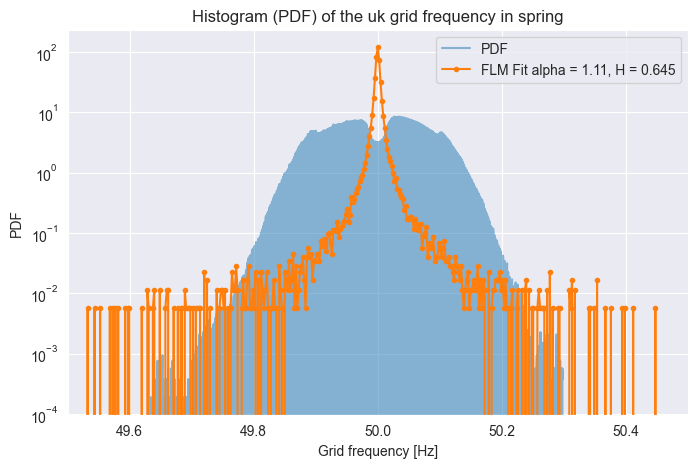

In [6]:
plt.figure(figsize=(8, 5))

# Plot the PDF of the data
counts, bin_edges = np.histogram(df['Value'], bins=1000, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, counts, label='PDF', alpha=0.5)

def pdf_distance(real_pdf, sim_pdf):
    return np.mean((real_pdf - sim_pdf)**2)

best_score = np.inf
best_params = None

for alpha in np.arange(0.01, 2.00, 0.05):
    sim = flm(H, alpha, N=10000, trunc=1000, scale=sigma) + 50
    sim_counts, _ = np.histogram(sim, bins=bin_edges, density=True)
    score = pdf_distance(counts, sim_counts)

    if score < best_score:
        best_score = score
        best_params = (alpha, H, sigma)

print("Best alpha:", best_params[0], "with score:", best_score)


for alpha in [best_params[0]]:
    t1 = time.time()
    flm_array = flm(H, alpha, N//100, trunc, sigma)
    # Generate FLM Fit data
    flm_data = [elt + 50 for elt in flm_array]
    flm_counts, flm_bin_edges = np.histogram(flm_data, bins=1000, density=True)
    flm_bin_centers = 0.5 * (flm_bin_edges[:-1] + flm_bin_edges[1:])
    plt.plot(flm_bin_centers, flm_counts, label=f'FLM Fit alpha = {alpha}, H = {round(H, 3)}', marker='.')
    t2 = time.time()
    print(f"Alpha={alpha} DONE in {t2-t1:.2f} seconds")

# Use a log scale for the y-axis
plt.yscale('log')

plt.xlim(49.5, 50.5)
# Labels and legend
plt.xlabel('Grid frequency [Hz]')
plt.ylabel('PDF')
plt.title(f'Histogram (PDF) of the {grid_name} grid frequency in {season}')
plt.legend()
plt.show()

In [7]:
# from scipy.optimize import minimize
#
# def score_fn(params):
#     alpha, H = params
#     sim = flm(H, alpha, N=10000, trunc=1000, scale=sigma) + 50
#     sim_counts, _ = np.histogram(sim, bins=bin_edges, density=True)
#     return pdf_distance(counts, sim_counts)
#
# result = minimize(score_fn, x0=[1.9, 0.75], bounds=[(0.2, 2.0), (0.2, 2.0)])
# print(result)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 115.25554918987105
        x: [ 1.900e+00  7.500e-01]
      nit: 2
      jac: [-1.726e+08 -4.533e+08]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [ ]:
alpha = 1.21
# --- Generate Fractional Lévy Noise ---
noise = flm(H=H, alpha=alpha, N=N//10, trunc=trunc, scale=sigma)

# --- Define γ_eff(ω) ---
def gamma_eff(omega):
    if -omega_db <= omega <= omega_db:
        return gamma1
    elif omega < -omega_db:
        return gamma2 + (gamma2 - gamma1) * omega_db / abs(omega)
    else:
        return gamma2 + (gamma1 - gamma2) * omega_db / abs(omega)

# --- Simulate the stochastic differential equation ---
omega = np.zeros(N//10)
for t in range(1, N//10):
    gamma = gamma_eff(omega[t-1])
    domega = -gamma * omega[t-1] * dt + noise[t]
    omega[t] = omega[t-1] + domega

# --- Plots ---
time = np.arange(N//10) * dt / 60  # in minutes

plt.figure(figsize=(10, 4))
plt.plot(time, omega, label='Simulated Frequency')
plt.title("Simulated Grid Frequency Deviation")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency Deviation (Hz)")
plt.grid(True)
plt.legend()

plt.figure()
plt.hist(omega, bins=1000, density=True, alpha=0.75)
plt.title("Histogram (PDF) of Frequency Deviations")
plt.xlabel("Frequency Deviation (Hz)")
plt.ylabel("Density")
plt.grid(True)

from statsmodels.tsa.stattools import acf
lags = 600
acf_vals = acf(omega, nlags=lags, fft=True)

plt.figure()
plt.plot(np.arange(lags+1), acf_vals)
plt.title("Autocorrelation Function of Simulated Frequency")
plt.xlabel("Lag (seconds)")
plt.ylabel("ACF")
plt.grid(True)

plt.tight_layout()
plt.show()